In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from pylab import *


In [2]:
from qutip import *

In [3]:
import numpy as np
import scipy as sp
import cmath
from scipy.constants import e, h, hbar

## 0. Physical constants

In [4]:
f0 = h/(2*e) #magnetic flux quantum
eps0 = 8.854e-12 #dielectric constant

# 1. Qubit-resonator system stationary parameters

## 1.1 SQUID parameters

In [5]:
Fext = 0
jc = 5.27e5 #critical current density
eps = 9 #oxide epsilon (alumina )
o_thick = 3e-9 #oxide thickness
Square_jj_l = 131e-9*194e-9 #left JJ square
Square_jj_r = 190e-9*295e-9 #Right JJ square
Ic_jj_l=jc*Square_jj_l #left JJ CC
Ic_jj_r=jc*Square_jj_r #Right JJ CC
Cj = eps*eps0/o_thick*(Square_jj_l+Square_jj_r) #SQUID capacitance
Ej_l = Ic_jj_l*f0/(2*np.pi)/h #left JJ energy
Ej_r = Ic_jj_r*f0/(2*np.pi)/h #right JJ energy
d = (Ej_r-Ej_l)/(Ej_r+Ej_l) #SQUID assymetry coef
def Ej(): #Define SQUID josephson energy
    return (Ej_r+Ej_l)*np.sqrt((np.cos(np.pi*Fext/f0))**2+d**2*(np.sin(np.pi*Fext/f0))**2)
print('SQUID max Josephson energy (GHz) =', Ej()*1e-9)
print('SQUID asymmetry =', d)

SQUID max Josephson energy (GHz) = 21.323382050047147
SQUID asymmetry = 0.37606795639791807


## 1.2 Parameters of isolated transmon

In [6]:
Csh = 90e-15 #Shunted qubit-ground capasitance
Cq_sum = Csh+Cj #Total qubit capacitance
Ec_q = e**2/(2*Cq_sum*h) #Qubit charge energy
v_q = np.sqrt(8*Ec_q*Ej())-Ec_q #isolated qubit 01 transition frequency

print('Transmon charge energy (GHz) = ', Ec_q*1e-9)
print('Transmon 01 transition frequency (GHz) = ', (np.sqrt(8*Ec_q*Ej())-Ec_q)*1e-9)
print('Transmon 12 transition frequency (GHz) = ', ((2*np.sqrt(8*Ec_q*Ej())-3*Ec_q)*1e-9-(np.sqrt(8*Ec_q*Ej())-Ec_q)*1e-9))
print('Transmon anharmonicity (GHz) = ', -Ec_q*1e-9 )

Transmon charge energy (GHz) =  0.2101716671334146
Transmon 01 transition frequency (GHz) =  5.777529564144671
Transmon 12 transition frequency (GHz) =  5.567357897011255
Transmon anharmonicity (GHz) =  -0.2101716671334146


## 1.3 Parameters of resonator 

In [7]:
Ng = 0 #External charge
Cg = 2e-15 #Resonator-qubit capacitance
Ck = 5e-15 #Resonator-feedline capacitance
Cr = 500e-15 #Resonator-ground capacitance
Lr = 2e-9 #Resonator inductance


def C_ast(): # defining C*
    return np.sqrt(Cq_sum*Cg+Cq_sum*Ck*Cg*Ck+Cq_sum*Cr+Cg*Cr)
def Ec(): # defining system charge energy
    return e**2*(Cg+Ck+Cr)/(2*h*C_ast()**2)
def wr(): #defining resonator frequency
    return 1/np.sqrt(Lr*C_ast()**2/(Cq_sum+Cg))

print('Resonator frequency (GHz) = ', wr()/(2*np.pi)*1e-9)
print('Charge energy of the qubit-resonator system (GHz) = ', Ec()*1e-9)
print('Ej/Ec = ', Ej()/Ec())

Resonator frequency (GHz) =  5.02309799656072
Charge energy of the qubit-resonator system (GHz) =  0.20777417382842983
Ej/Ec =  102.62768301345766


### Plot features

In [8]:
def spines(ax=None):
    if ax is None:
        ax = plt.gca()
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))
    
def annotate_distance(ax, text, point1, point2, linestyle, fontsize, textoffset = (0.1,0)):
    ax.annotate('', point1, point2, \
            arrowprops={'arrowstyle':'<->', 'linestyle':linestyle, "facecolor":"black"}, fontsize=fontsize);
    ax.annotate(text, point1, (0.5*(point1[0]+point2[0])+textoffset[0], 0.5*(point1[1]+point2[1])+textoffset[1]),
                fontsize=fontsize)

In [9]:
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = '1'

In [10]:
font = {"size":15}
matplotlib.rc("font", **font)

## 1.4 Building Qubit-resonator system Hamiltonian

In [11]:
N_q = 20 # Number of qubit energy levels
N_r = 5 # Number of resonator energy levels

def a(): #define resonator annihilation operator
    return destroy(N_r) 
def n(): #define particle number operator
    return Qobj(diag(arange(-N_q, N_q+1, 1)))

def H_q_isolated():  #define isolated qubit Hamiltonian
    H_q = 4*Ec()*n()**2 - Ej()/2*(Qobj(diag(ones(2*N_q), 1) + diag(ones(2*N_q), -1)))
    return H_q
def H_q(): #define qubit part of Hamiltonian (entangled with resonator)
    return tensor(identity(N_r), H_q_isolated()) 

def H_r(): #define resonator Hamiltonian
    H_r = wr()/2/np.pi*(a().dag()*a()+1/2) 
    return tensor(H_r, identity(2*N_q+1))
def g(): #define coupling strength
    return 2*e*Cg/C_ast()*sqrt(hbar*wr()/2/(Cq_sum+Cg))/h 
def H_i(): #define interaction Hamiltonian
    return g()*1j*tensor(a().dag()-a(), n())

def H():
    return H_q()+H_r()+H_i()

print('Qubit-resonator coupling strength (MHz) = ', g()/1e6)
print('E(2)-E(0) (GHz) = ', (H().eigenenergies()[2]-H().eigenenergies()[0])/1e9)

Qubit-resonator coupling strength (MHz) =  18.702321707629878
E(2)-E(0) (GHz) =  5.7384519446315405


In [12]:
Fext = 0
Fs = np.linspace(-2*f0, 2*f0, 401)
E_0 = H().eigenenergies()[0]
evals = []
for Fext in Fs:
    #print("\rFext/f0:", Fext/f0, flush=True, end="")
    evals.append(H().eigenenergies())
evals = array(evals)

## 1.5 Plotting eigenenergies

(-2.0, 2.0)

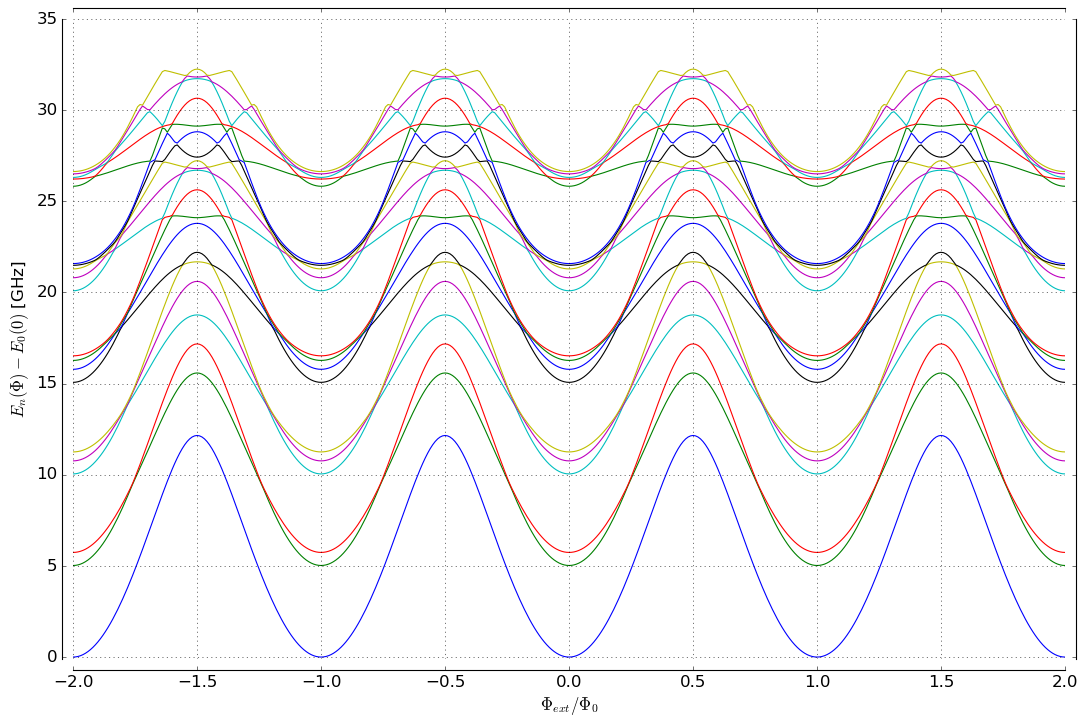

In [13]:
for i in range(0, 20):
    plt.plot(Fs/f0, (evals[:, i]-E_0)/1e9)
spines()
plt.ylabel("$E_n(\Phi) - E_0(0)$ [GHz]")
plt.xlabel("$\Phi_{ext}/\Phi_0$")
plt.gcf().set_size_inches(16,10)
plt.grid()
plt.ylim(-0.1,35)
plt.xlim(-2.0,2.0)

# plt.savefig("levels.pdf",bbox_inches='tight')

## 1.6 Plotting transition frequencies

(-2.0, 2.0)

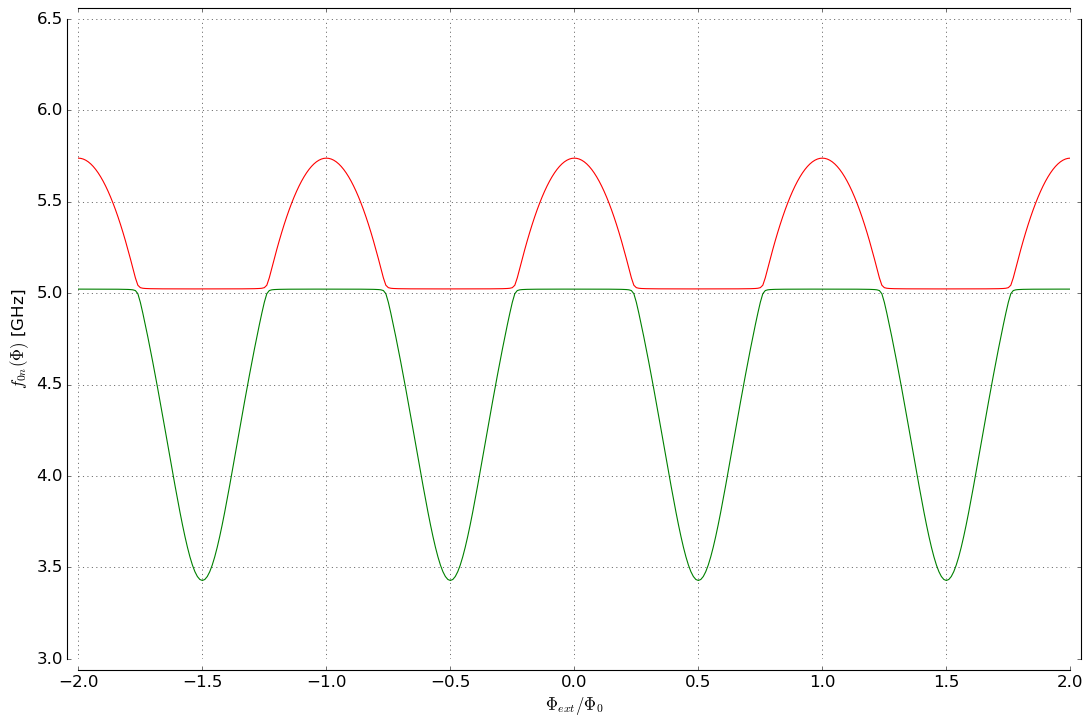

In [14]:
for i in range(0, 20):
    plt.plot(Fs/f0, (evals[:, i]-evals[:, 0])/1e9)
spines()
plt.ylabel("$f_{0n}(\Phi)$ [GHz]")
plt.xlabel("$\Phi_{ext}/\Phi_0$")
plt.gcf().set_size_inches(16,10)
plt.grid()
plt.ylim(3,6.5)
plt.xlim(-2.0,2.0)

# plt.savefig("levels.pdf",bbox_inches='tight')

## 1.7 Qubit-resonator system energy diagram

In [15]:
Fext=0 #qubit at the sweet spot
N_r = 10 #Number of resonator states
nqs = range(0, 2*N_q+1, 1) #range of qubit states
nrs = range(0, N_r, 1) #range of resonator states
evecs = H().eigenstates()[1] #system eigenstates
E_0 = H().eigenenergies()[0] #system ground eigenenergy
evecs_q = H_q_isolated().eigenstates()[1] #isolated qubit eigenstates
colors = ["b", "green", "red", "aqua", "indigo"]

qubit_states_taken = 5

E_rs = zeros((N_r, qubit_states_taken))

for state in evecs:
    found = False
    for n_r in nrs:
        for n_q in nqs[:5]:
            base_vec = tensor(basis(N_r, n_r), evecs_q[n_q]) #system psi function
            if abs((state.dag()*base_vec).data[0,0]) > 0.5:
                E = (base_vec.dag()*H()*base_vec).data[0,0]
                E_rs[n_r, n_q] = real(E)
                #print(abs((state.dag()*base_vec).data[0,0]), n_r, n_q, E-E_0)

(-1, 40)

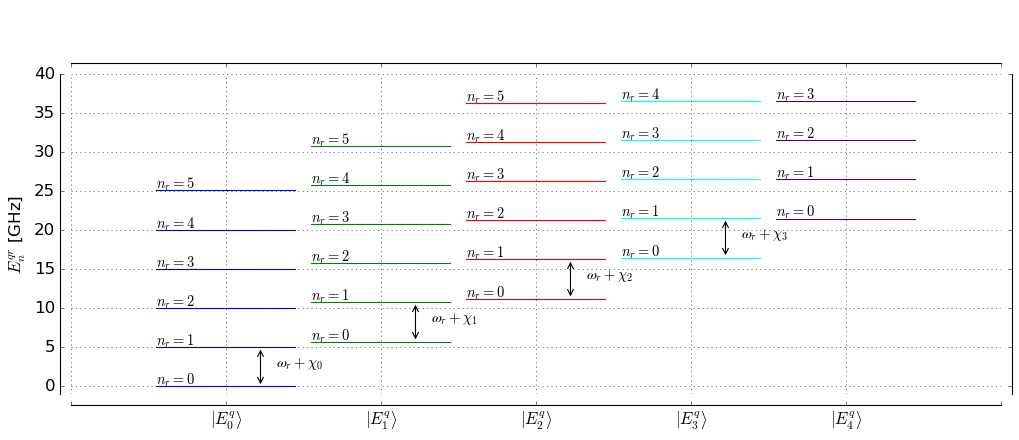

In [16]:
X = array([-0.45, 0.45])

for n_r in nrs[:6]:
    for n_q in nqs[:5]:
        plt.plot(X+n_q, (np.around(ones_like(X)*E_rs[n_r, n_q] - E_0, 5))/1e9, colors[n_q])
        plt.annotate("$n_r=%i$"%n_r, (X[0]+n_q, (E_rs[n_r, n_q] - E_0+0.2e9)/1e9),
                     (X[0]+n_q, (E_rs[n_r, n_q] - E_0+0.2e9)/1e9), fontsize=13)
        if n_r==1 and n_q<4:
            annotate_distance(plt.gca(), "$ω_r + \chi_%i$"%n_q, 
                              (n_q+X[-1]/2, (E_rs[n_r-1, n_q] - E_0)/1e9), (n_q+X[-1]/2, (E_rs[n_r, n_q] - E_0)/1e9), None, 13)
        
spines()
plt.gcf().set_size_inches(15, 5)
plt.xticks(linspace(-1, 5, 7))
#plt.yticks(linspace(0, 40, 10))
plt.gca().set_xticklabels([""]+[r"$\left.|E^q_%i\right>$"%i for i in range(0,5)])
plt.ylabel("$E^{qr}_n$ [GHz]")
plt.grid()
plt.ylim(-1, 40)

## 1.8 Resonator dispersive shifts

In [17]:
Fext = 0
Fs = np.linspace(-0.15*f0, 0, 201)
evals = []

for Fext in Fs:
    evals.append(H().eigenenergies())
    evals_q, evecs_q = H_q_isolated().eigenstates()
    evals_q = evals_q - evals_q[0]
evals = array(evals)

In [18]:
v_q

5777529564.1446705

In [19]:
(v_q - wr()/2/pi)/1e9

0.754431567583951

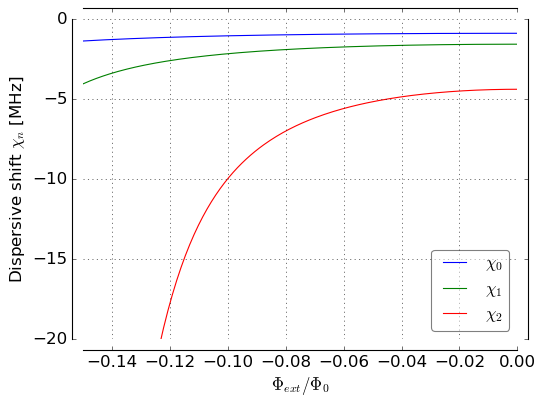

In [20]:
if (v_q - wr()/2/pi)/1e9 > 0.2:
    plt.plot(Fs/f0, (evals[:, 1] - evals[:, 0] -wr()/2/pi)/1e6, label="$\chi_0$")
    plt.plot(Fs/f0, (evals[:, 4] - evals[:, 2] -wr()/2/pi)/1e6, label="$\chi_1$")
    plt.plot(Fs/f0, (evals[:, 8] - evals[:, 5] -wr()/2/pi)/1e6, label="$\chi_2$")
    
elif 0 < (v_q - wr()/2/pi)/1e9 < 0.2:
    plt.plot(Fs/f0, (evals[:, 1] - evals[:, 0] -wr()/2/pi)/1e6, label="$\chi_0$") 
    plt.plot(Fs/f0, (evals[:, 5] - evals[:, 2] -wr()/2/pi)/1e6, label="$\chi_1$")
    plt.plot(Fs/f0, (evals[:,11] - evals[:, 6] -wr()/2/pi)/1e6, label="$\chi_2$")
    
else:
    plt.plot(Fs/f0, (evals[:, 2] - evals[:, 0] -wr()/2/pi)/1e6, label="$\chi_0$")
    plt.plot(Fs/f0, (evals[:, 4] - evals[:, 1] -wr()/2/pi)/1e6, label="$\chi_1$")
    plt.plot(Fs/f0, (evals[:, 7] - evals[:, 3] -wr()/2/pi)/1e6, label="$\chi_2$")

plt.gcf().set_size_inches(7, 5)
plt.ylim(-20, 0)
plt.xlim(Fs[0]/f0, 0)
plt.grid()
plt.ylabel("Dispersive shift $\chi_n$ [MHz]")
plt.xlabel("$\Phi_{ext}/\Phi_0$")

spines()
plt.legend(fancybox=True, framealpha=0.5, loc="lower right", fontsize=15)
#plt.xlabel(r"$\Phi_{ext} [\Phi_0]$", position=(1,0))
# plt.ylabel("Shifts [MHz]")
#plt.gca().annotate(r"$\Delta_\omega(\Phi_{ext}=0)$ = %.1f GHz"%(ω_r()/2/pi/1e9 - ν_q), 
               #    (Φs[0], plt.gca().get_ylim()[0]), xytext=(0,-0.185),
                   #            textcoords="axes fraction")


In [21]:
Fext = 0
Fs = np.linspace(-2*f0, 2*f0, 201)
evals = []

for Fext in Fs:
    evals.append(H().eigenenergies())
    evals_q, evecs_q = H_q_isolated().eigenstates()
    evals_q = evals_q - evals_q[0]
evals = array(evals)

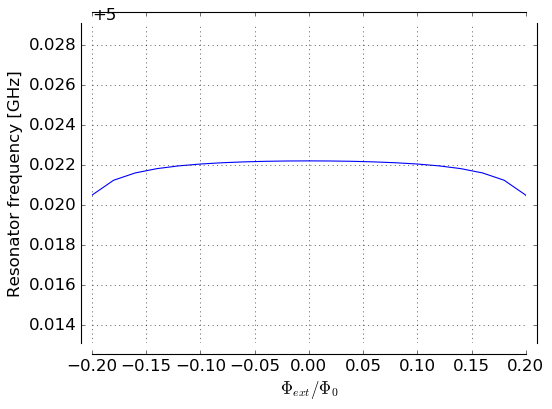

In [22]:
if (v_q - wr()/2/pi)/1e9 > 0.2:
    plt.plot(Fs/f0, (evals[:, 1] - evals[:, 0])/1e9)
#    plt.plot(Fs/f0, (evals[:, 4] - evals[:, 2])/1e9)
#    plt.plot(Fs/f0, (evals[:, 8] - evals[:, 5])/1e9)
    
elif 0 < (v_q - wr()/2/pi)/1e9 < 0.2:
    plt.plot(Fs/f0, (evals[:, 1] - evals[:, 0])/1e9) 
#    plt.plot(Fs/f0, (evals[:, 5] - evals[:, 2])/1e9)
#    plt.plot(Fs/f0, (evals[:,11] - evals[:, 6])/1e9)
else:
    plt.plot(Fs/f0, (evals[:, 2] - evals[:, 0])/1e9)
#    plt.plot(Fs/f0, (evals[:, 4] - evals[:, 1])/1e9)
#    plt.plot(Fs/f0, (evals[:, 7] - evals[:, 3])/1e9)

plt.gcf().set_size_inches(7, 5)
plt.ylim(wr()/2/pi/1e9-0.01, wr()/2/pi/1e9+0.006)
plt.xlim(-0.2, 0.2, 0)
plt.grid()
plt.ylabel("Resonator frequency [GHz]")
plt.xlabel("$\Phi_{ext}/\Phi_0$")

spines()

## 1.9 Single tone spectroscopy (full spectrum)

In [23]:
Fext = 0
Fs = np.linspace(-2*f0, 2*f0, 601)
evals_r = []

for Fext in Fs:
    x = H().eigenenergies()
    v_q = np.sqrt(8*Ec_q*Ej())-Ec_q
    
    if (v_q-wr()/2/pi)/1e9 > 0.2:
        evals_r.append(x[1] - x[0])
    
    elif 0 < (v_q - wr()/2/pi)/1e9 < 0.2:
        evals_r.append(x[1] - x[0])        
    
    else: 
        evals_r.append(x[2] - x[0]) 
        
evals_r = array(evals_r)    

In [24]:
wr()/2/pi

5023097996.5607195

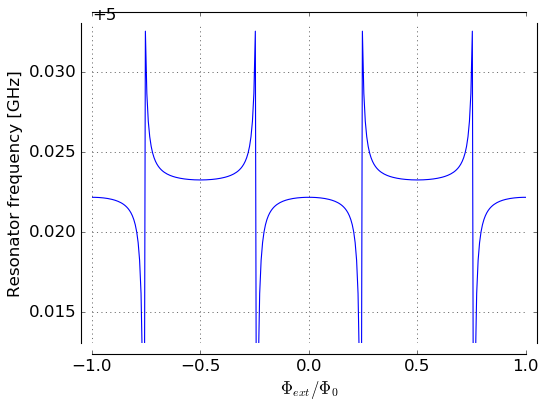

In [25]:
plt.plot(Fs/f0, (evals_r)/1e9)

plt.gcf().set_size_inches(7, 5)
plt.ylim(wr()/2/pi/1e9-10e-3, wr()/2/pi/1e9+10e-3, 0)
plt.xlim(-1, 1, 0)
plt.grid()
plt.ylabel("Resonator frequency [GHz]")
plt.xlabel("$\Phi_{ext}/\Phi_0$")

spines()